### Imports

In [1]:
import jax.numpy as jnp
from jax import jit
from pekf.parallel import ekf, eks
from pekf.sequential import ekf as seq_ekf, eks as seq_eks, ckf as seq_ckf, cks as seq_cks
from pekf.models.linear import get_data, make_parameters
from pekf.utils import MVNormalParameters

### Input parameters

In [2]:
r = 0.5
q = 0.1
x0 = jnp.array([0., 0.])  # initial true location

T = 1000  # number of observations

/u/95/corenfa1/unix/PycharmProjects/parallelEKF/venv/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Get parameters

In [3]:
A, H, Q, R, observation_function, transition_function = make_parameters(r, q)

In [4]:
observation_function = jnp.vectorize(observation_function, signature="(m)->(d)")
transition_function = jnp.vectorize(transition_function, signature="(m)->(m)")

### Get data

In [5]:
ts, true_states, observations = get_data(x0, A, H, R, Q, T, 42)

### We can now run the filter

Initial state guess

In [6]:
m = jnp.array([0., 0.])
P = jnp.eye(2)

initial_guess = MVNormalParameters(m, P)

### We can now run the smoother

Run the filters

In [7]:
par_ekf_filtered = ekf(initial_guess, observations, transition_function, Q, observation_function, R)
seq_ekf_filtered = seq_ekf(initial_guess, observations, transition_function, Q, observation_function, R)
seq_ckf_filtered = seq_ckf(initial_guess, observations, transition_function, Q, observation_function, R)

Compare:

In [8]:
print(jnp.max(jnp.abs(par_ekf_filtered.mean - seq_ekf_filtered.mean)))
print(jnp.max(jnp.abs(par_ekf_filtered.mean - seq_ckf_filtered.mean)))

print(jnp.max(jnp.abs(par_ekf_filtered.cov - seq_ekf_filtered.cov)))
print(jnp.max(jnp.abs(par_ekf_filtered.cov - seq_ckf_filtered.cov)))

8.940697e-08
8.940697e-08
1.4901161e-08
1.4901161e-08


In [9]:
par_ekf_filtered.cov

DeviceArray([[[ 0.21933334, -0.06533333],
              [-0.06533333,  0.31733334]],

             [[ 0.12335366, -0.03207317],
              [-0.03207317,  0.17146343]],

             [[ 0.10641204, -0.02023148],
              [-0.02023148,  0.13675927]],

             ...,

             [[ 0.10220842, -0.01556246],
              [-0.01556246,  0.1255521 ]],

             [[ 0.10220842, -0.01556246],
              [-0.01556246,  0.1255521 ]],

             [[ 0.10220842, -0.01556246],
              [-0.01556246,  0.12555212]]], dtype=float32)

Run the smoothers

In [10]:
par_eks_smoothed = eks(transition_function, Q, par_ekf_filtered, par_ekf_filtered.mean)
seq_eks_smoothed = seq_eks(transition_function, Q, par_ekf_filtered)
seq_cks_smoothed = seq_cks(transition_function, Q, par_ekf_filtered)

transforms: [('batch', {'batch_dims': (0,)})]
[[ 0.2214607   0.11073035]
 [ 0.15542476  0.07771238]
 [ 0.16394147  0.08197074]
 ...
 [ 0.08031288  0.04015644]
 [ 0.02837458  0.01418729]
 [-0.09243698 -0.04621849]]
transforms: [('batch', {'batch_dims': (0,)})]
[[[ 0.6957575  -0.11878788]
  [-0.11878785  0.8739396 ]]

 [[ 0.46612108 -0.08608839]
  [-0.08608837  0.5952537 ]]

 [[ 0.4178763  -0.05963326]
  [-0.05963327  0.50732625]]

 ...

 [[ 0.40557283 -0.0472136 ]
  [-0.0472136   0.4763932 ]]

 [[ 0.40557283 -0.0472136 ]
  [-0.0472136   0.4763932 ]]

 [[ 0.40557283 -0.04721359]
  [-0.0472136   0.4763932 ]]]
[[0.5 0. ]
 [0.  0.5]]
transforms: [('batch', {'batch_dims': (0,)})]
[[[ 0.21933334 -0.06533333]
  [-0.06533333  0.31733334]]

 [[ 0.12335366 -0.03207317]
  [-0.03207317  0.17146343]]

 [[ 0.10641204 -0.02023148]
  [-0.02023148  0.13675927]]

 ...

 [[ 0.10220842 -0.01556246]
  [-0.01556246  0.1255521 ]]

 [[ 0.10220842 -0.01556246]
  [-0.01556246  0.1255521 ]]

 [[ 0.10220842 -0.015

In [11]:
print(jnp.max(jnp.abs(par_eks_smoothed.mean - seq_eks_smoothed.mean)))
print(jnp.max(jnp.abs(par_eks_smoothed.mean - seq_cks_smoothed.mean)))

print(jnp.max(jnp.abs(par_eks_smoothed.cov - seq_eks_smoothed.cov)))
print(jnp.max(jnp.abs(par_eks_smoothed.cov - seq_cks_smoothed.cov)))

5.9604645e-08
5.9604645e-08
1.4901161e-08
2.9802322e-08


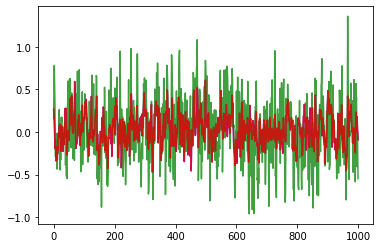

In [14]:
import matplotlib.pyplot as plt
plt.plot(par_eks_smoothed.mean[:, 0], alpha=0.75, color="b")
plt.plot(true_states[:, 0], alpha=0.75, color="g")
plt.plot(seq_cks_smoothed.mean[:, 0], alpha=0.75, color="r")


In [15]:
seq_cks_smoothed.mean

DeviceArray([[ 0.2655578 ,  0.13277891],
             [ 0.18002579,  0.0900129 ],
             [ 0.13586028,  0.06793014],
             ...,
             [ 0.06025634,  0.03012816],
             [-0.01235226, -0.00617614],
             [-0.09243698, -0.04621849]], dtype=float32)